# Example BANTS application to mock time series data 

Let's demonstrate how to use the `bants` class on a simple mock example. First we need to import `bants` and other modules to make the mock data and do some plotting...

In [1]:
import sys
path = '/Users/Rob/work/bants/' # Give your path to bants here
sys.path.append(path + 'source/') 
from bants import bants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Now we generate some mock time series data using an n-d Langevin system...

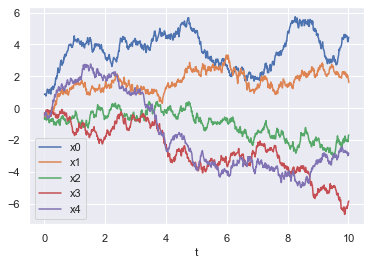

In [2]:
# Evolve the n-d Langevin system
def L_syst_gen(n,runtime,stepsize):    
    # Specify simple drift function with random linear couplings
    def f(x):
        a = np.random.normal(0.0,1.0,size=len(x))
        b = np.random.normal(0.0,1.0,size=len(x))
        return a*x + b*x[np.random.randint(0,len(x),size=len(x))]    
    # Initialise process and run
    t, x = 0.0, np.random.normal(0.0,1.0,size=n)
    out_store = [] 
    while t < runtime:
        t += stepsize
        x += -(stepsize*f(x))+(np.sqrt(stepsize)*np.random.normal(0.0,1.0,size=n))
        out_store.append(np.append(t,x))        
    # Output time series as a pandas dataframe
    out_df = pd.DataFrame(np.asarray(out_store),columns=['t']+['x'+str(ni) for ni in range(0,n)]).set_index('t')
    return out_df
# Choose number of dimensions, total runtime and stepsize
n = 5
runtime = 10.0
stepsize = 0.01
# Run Langevin system and plot output
df = L_syst_gen(n,runtime,stepsize)
df.plot()
plt.show()

Let's first apply differencing to the data as a pre-processing step...

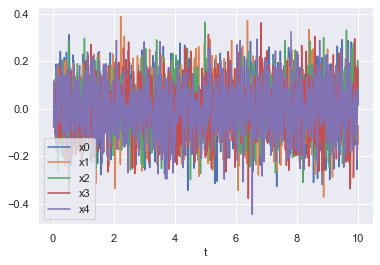

In [3]:
ddf = df.diff().iloc[1:]
ddf.plot()
plt.show()

The `bants` class works in the same pattern as a `scikit-learn` estimator. We initialise `bants('AR-GP')` and fit with the `bants.fit` method to the differenced dataframe with sucessive runs of the BFGS optimiser followed by the Nelder-Mead optimiser for termination...

Best fit hyperparameters are: {'nu': 5, 'hsq': array([118.47506925,   9.48190719, 315.84742843,  23.12943847,
       204.84260316]), 'Psi_tril': array([ 1.32682950e+01,  3.67498733e-02,  4.24685835e+01,  3.77171852e-02,
       -1.89588061e+00,  1.29739799e+01,  7.29330902e-02, -6.92846108e+00,
       -4.04398567e-01,  1.40719696e+01,  1.68230403e-02,  9.49094883e-01,
       -1.23921212e-01, -5.88927048e-02,  1.33612423e+01])}
Best fit log-evidence value is: -22.529240444937873
Converged?: False
Number of function evaluations: 100


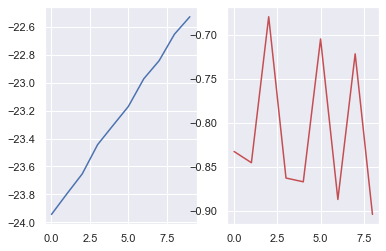

In [6]:
# Initialise class with 'AR-GP' network type (subsequently comment out if iterative runs of the cell are desired)
# bts = bants('AR-GP')
# Set the maximum number of algorithm iterations per fitting run and the optimiser. Works quite well to run 'BFGS'
# first for quick convergence toward the maximum evidence followed by Nelder-Mead for the termination.
bts.optimiser = 'Nelder-Mead' # 'BFGS'
bts.itmax = 10
nfunc_eval = 0
lnE_vals = []
for i in range(0,10):
    # Apply 'fit' method on the training dataframe to optimise Bayesian network hyperparameters where
    # standardisation of the training data is automatically performed unless the keyword standard=False
    bts.fit(ddf)
    # Update initial parameter values for next run
    bts.hsq_guess = bts.params['hsq']
    bts.Psi_tril_guess = bts.params['Psi_tril']
    # Store the log-evidence values from the run and add to the total number of function evaluations
    lnE_vals.append(bts.info['lnE_val'])
    nfunc_eval += bts.info['n_evaluations']
# Display the best fit hyperparameters
print('Best fit hyperparameters are: ' + str(bts.params))
# Display the best fit log-evidence value
print('Best fit log-evidence value is: ' + str(bts.info['lnE_val']))
# Ask if the fitting converged
print('Converged?: ' + str(bts.info['converged']))
# Display the number of function evaluations
print('Number of function evaluations: ' + str(nfunc_eval))
# Plot intermediate values and base-10 logarithmic improvements in the log-evidence after each run
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(lnE_vals,color='b')
ax2.plot(np.log10(np.asarray(lnE_vals)[1:]-np.asarray(lnE_vals)[:-1]),color='r')
plt.show()

Applying the `bants.predict` method, the fitted Bayesian network model can be used to generate predictive samples into the future with the `bts.results['sampler']` function...

In [13]:
# Future timepoint to sample up to
future_t = 10.3
# Apply bants.predict to forecast time series up to future time from training data last timepoint index
bts.predict(future_t)
# Number of prediction samples to generate at each timepoint
n_samples = 500
# Generate samples and store
pred_samps = bts.results['sampler'](n_samples)

...and we can now plot the predictive contours...

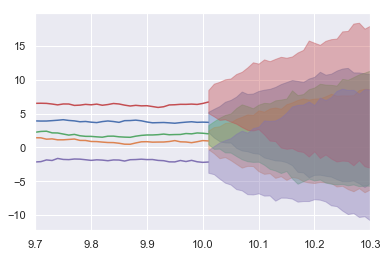

In [14]:
# Store colour palette
cp = sns.color_palette()
# Loop over dimensions of time series for plot
for i in range(0,5):
    # Cumulative sum of samples (integration) to remove differencing (remember to append training points to this!)
    fp = np.tensordot(df.values[0,i]*np.ones(1),np.ones(n_samples),axes=0) # First point
    dtd = np.tensordot(ddf.values[:,i],np.ones(n_samples),axes=0) # Differenced training data
    diff_preds = np.append(fp,np.append(dtd,pred_samps[:,i,:],axis=0),axis=0) # Append along time axis
    isamps = np.cumsum(diff_preds,axis=0)[-pred_samps.shape[0]:]
    # Compute 68% confidence
    c68l, c68u = np.quantile(isamps,[0.16,0.84],axis=1)
    # Use these to plot contours
    plt.plot(df.index,df.values[:,i],color=cp[i])
    plt.fill_between(np.arange(runtime+stepsize,future_t,stepsize),c68l,c68u,alpha=0.4,color=cp[i])
# Modify time axis for clearer display
axes = plt.gca()
axes.set_xlim([(2*runtime)-future_t,future_t])
plt.show()